TensorBoard to analyze and visualize training

In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import sys

from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter("runs/mnist2")  # identify a directory for saving results

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
input_size = 784 # images are 28x28
hidden_size = 500
num_classes = 10
num_epochs = 1
batch_size = 64
learning_rate = 0.01

In [3]:
# MNIST
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transforms.ToTensor(), download=True)

test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transforms.ToTensor())

In [4]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [5]:
len(train_dataset)

60000

In [6]:
len(train_loader)   # 938 = 60000 // 64 +1

938

In [7]:
examples = iter(train_loader)
samples, labels = next(examples)
samples.shape, labels.shape
# 100 images, only one color channel, resolution 28x28

(torch.Size([64, 1, 28, 28]), torch.Size([64]))

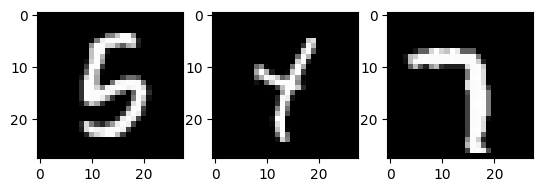

In [8]:
for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.imshow(samples[i][0], cmap='gray')
    # plt.show()

# create a grid and write it into writer
img_grid = torchvision.utils.make_grid(samples)
writer.add_image('mnist_images', img_grid)
writer.close()  # make sure all the output get flushed here

In [9]:
class net(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(net,self).__init__()
        self.l1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.l2 = nn.Linear(hidden_size, num_classes)
    # no softmax, because the loss_function do it for us
    def forward(self, x):
        x = self.l1(x)
        x = self.relu(x)
        x = self.l2(x)
        return x

In [10]:
model = net(input_size, hidden_size, num_classes)
model = model.to(device)

In [11]:
# loss function & optimizer

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr = learning_rate)

# model graph
writer.add_graph(model, samples.reshape(-1, 28*28).to(device))
writer.close()

In [12]:
# training loop
n_total_step = len(train_loader)

running_loss = 0.0
running_correct = 0

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # reshape from (100, 1, 28, 28) to (100, 784)
        images = images.reshape(-1, 28*28).to(device)
        labels = labels.to(device)

        # forward pass
        pred = model(images)
        loss = criterion(pred, labels)

        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, prediction = torch.max(pred, 1)
        running_correct += (prediction == labels).sum().item()


        if (i+1) % 100 == 0:
            print(f'eopch {epoch+1} / {num_epochs}, step {i+1} / {n_total_step}, loss = {loss.item():.4f}')
            writer.add_scalar('training loss', running_loss / 100, epoch * n_total_step + i)
            writer.add_scalar('acc', running_correct / 100, epoch * n_total_step + i)
            running_loss = 0.0
            running_correct = 0

eopch 1 / 1, step 100 / 938, loss = 0.4407
eopch 1 / 1, step 200 / 938, loss = 0.3501
eopch 1 / 1, step 300 / 938, loss = 0.1977
eopch 1 / 1, step 400 / 938, loss = 0.0806
eopch 1 / 1, step 500 / 938, loss = 0.2699
eopch 1 / 1, step 600 / 938, loss = 0.3355
eopch 1 / 1, step 700 / 938, loss = 0.0421
eopch 1 / 1, step 800 / 938, loss = 0.1670
eopch 1 / 1, step 900 / 938, loss = 0.0775


In [13]:
#  a recall curve

pred_label = []
pred_logits = []

# test

with torch.no_grad():
    n_correct = 0
    n_samples = 0
    for images, labels in test_loader:
        images = images.reshape(-1, 28*28).to(device)
        labels = labels.to(device)
        output = model(images)

        _, pred = torch.max(output, 1)
        n_samples += labels.shape[0]
        n_correct += (pred == labels).sum().item()

        output_logits = [nn.functional.softmax(o, dim=0) for o in output]
        pred_logits.append(output_logits)
        pred_label.append(pred)

In [14]:
pred_logits = torch.cat([torch.stack(batch) for batch in pred_logits])
pred_label = torch.cat(pred_label)

In [15]:
pred_logits.shape, pred_label.shape

(torch.Size([10000, 10]), torch.Size([10000]))

In [16]:
acc = 100.0 * n_correct / n_samples
print(f'Acc of the network on the test :{acc} %')

Acc of the network on the test :95.46 %


In [17]:
pred_label[:2] == 2

tensor([False,  True], device='cuda:0')

In [18]:
n = 0
for i in range(num_classes):
    labels_i = pred_label == i
    preds_i = pred_logits[:, i]
    if n < 5:
        print(pred_label)
        print(labels_i, "  ", preds_i)
    writer.add_pr_curve(str(train_dataset.classes[i]), labels_i, preds_i, global_step=0)
    writer.close()
    n += 1

tensor([7, 2, 1,  ..., 4, 5, 6], device='cuda:0')
tensor([False, False, False,  ..., False, False, False], device='cuda:0')    tensor([6.2710e-08, 9.4496e-15, 9.9134e-10,  ..., 5.8368e-13, 5.0057e-05,
        3.1711e-07], device='cuda:0')
tensor([7, 2, 1,  ..., 4, 5, 6], device='cuda:0')
tensor([False, False,  True,  ..., False, False, False], device='cuda:0')    tensor([7.4163e-08, 6.5887e-04, 9.9998e-01,  ..., 3.1572e-07, 9.6078e-07,
        5.0968e-10], device='cuda:0')
tensor([7, 2, 1,  ..., 4, 5, 6], device='cuda:0')
tensor([False,  True, False,  ..., False, False, False], device='cuda:0')    tensor([1.5293e-05, 9.9932e-01, 6.3492e-07,  ..., 6.8693e-12, 2.3208e-10,
        2.8662e-07], device='cuda:0')
tensor([7, 2, 1,  ..., 4, 5, 6], device='cuda:0')
tensor([False, False, False,  ..., False, False, False], device='cuda:0')    tensor([7.6817e-06, 2.3126e-05, 4.3919e-08,  ..., 6.7951e-09, 2.9844e-04,
        2.0305e-04], device='cuda:0')
tensor([7, 2, 1,  ..., 4, 5, 6], device='cud